In [76]:
from bs4 import BeautifulSoup 
import requests 
import re
from scipy.integrate import odeint, solve_ivp
from scipy.stats import chisquare, chi2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize,curve_fit
from sklearn.metrics import r2_score, mean_squared_error as mse

# Get the data
Url's of interesting countries, in our scenarion it will be Poland, Malysia and Belgium.

In [77]:
bg = 'https://www.worldometers.info/coronavirus/country/belgium/'
mal = 'https://www.worldometers.info/coronavirus/country/malaysia/'
pl = 'https://www.worldometers.info/coronavirus/country/poland/'

1. Get the content of page

2. Use regexp to get this kind of data: <br>
&emsp; name: 'Recovery Rate',<br>
&emsp; color: '#8ACA2B',<br>
&emsp; lineWidth: 5,<br>
&emsp; data: [ numbers ]

3. Split names and data

4. Make data more userfirendly - to floats and then to np.array

5. Names of each array

6. Get dates

In [78]:
def get_data(url):
    #1
    page = requests.get(url) 
    #2
    names = re.findall(r'series: \[\{\s*name: \'([a-zA-Z\s ]*)\'[a-zA-Z\#0-9\s\n\,\.\'\:\- ]*data: \[([0-9\,\s\.null\- ]*)\]', page.text)
    #3
    datas = [n[1] for n in names]
    names = [n[0] for n in names]
    #4
    datas = [d.split(',') for d in datas]
    datas = [[ 0 if d == 'null' else float(d) for d in data] for data in datas]
    datas = np.nan_to_num(datas,0)
    datas = np.array(datas)
    datas[datas<0]=0
    print('datas shape:',datas.shape)
    #5
    for i, n in enumerate(names):
        print(i,n)
    #6
    dates = re.findall(r'categories: \[([\"A-Za-z\s0-9\, ]*)\]\n', page.text)
    if len(dates) > 0: dates = dates[0].replace('"','').split(',')
    
    return names, datas, dates

### Fit exp or gauss to existing data

In [79]:
def my_exp(x, a, b=0): 
    if type(a) is np.ndarray:
        a, b = a
    return a*np.exp(b*x) 
    
def my_gauss(x, a, mu=0, sigma=0.1):
    if type(a) is np.ndarray:
        a, mu, sigma = a
    return a*1/np.sqrt(2*sigma)/2*np.exp(-(x-mu)**2/(2*sigma**2))

def my_sigmoid(x, a, b=0, c=0):
    if type(a) is np.ndarray:
        a, b, c = a
    return c / (1.0 + np.exp(-a*(x-b)))

#param, param_cov = curve_fit(my_exp, x, y) 

# Real data

## Poland overwiev

## Poland
Koronawirus COVID-19. Czwarty etap znoszenia ograniczeń [30.05.2020] <br>
Zniesienie obowiązku zasłaniania ust i nosa w przestrzeni otwartej [30.05.2020] <br>
Koronawirus COVID-19. Trzeci etap znoszenia ograniczeń [18.05.2020] <br>
Koronawirus COVID-19. Drugi etap znoszenia ograniczeń [04.05.2020] <br>
Koronawirus COVID-19. Pierwszy etap znoszenia ograniczeń [20.04.2020] <br>
Obowiązek zasłaniania ust i nosa [16.04.2020] <br>
Ograniczenia na Wielkanoc [09.04.2020] <br>
Wprowadzenie kolejnych ograniczeń i zakazów w Polsce [31.03.2020] <br>
Nowe restrykcje i ograniczenia wprowadzone w Polsce [24.03.2020] <br>
Stan zagrożenia epidemicznego w Polsce – jakie ograniczenia wprowadzono? [16.03.2020] <br> 
https://www.medonet.pl/koronawirus-pytania-i-odpowiedzi/sars-cov-2,koronawirus---obostrzenia-w-polsce--etapy-znoszenia-ograniczen--aktualne-dane-,artykul,98382723.html

In [80]:
names, datas, dates = get_data(pl)

datas shape: (11, 125)
0 Currently Infected
1 Death Rate
2 Cases
3 Cases
4 Daily Cases
5 Currently Infected
6 Deaths
7 Deaths
8 Daily Deaths
9 New Recoveries
10 Death Rate


In [81]:
Idaily = datas[4]
Ddaily = datas[-3]
Rdaily = datas[-2]

Itotal = datas[0]
Dtotal = datas[-4]
Rtotal = np.cumsum(Rdaily)

In [82]:
#restrictions
r0 = dates.index('Mar 16')
r1 = dates.index('Mar 24')
r2 = dates.index('Mar 31')
#freedoms
f0 = dates.index('Apr 20')
f1 = dates.index('May 04')
f2 = dates.index('May 18')
f3 = dates.index('May 30')

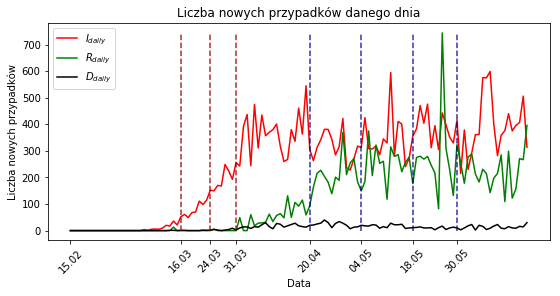

In [83]:
plt.figure(figsize=(9,4))
plt.plot(Idaily, 'r', label=r'$I_{daily}$')
plt.plot(Rdaily, 'g', label=r'$R_{daily}$')
plt.plot(Ddaily, 'k', label=r'$D_{daily}$')

mx = np.ceil(np.max(Rdaily))
plt.plot([r0,r0],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([r1,r1],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([r2,r2],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([f0,f0],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f1,f1],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f2,f2],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f3,f3],[0,mx], '--', c='darkblue', alpha=0.8)

my_xticks = ['15.02','16.03','24.03','31.03','20.04','04.05','18.05','30.05']
x = [0,r0,r1,r2,f0,f1,f2,f3]
plt.xticks(x, my_xticks, rotation=45)

plt.title('Liczba nowych przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba nowych przypadków')
plt.legend()
plt.savefig('images/poland.png', bbox_inches='tight')

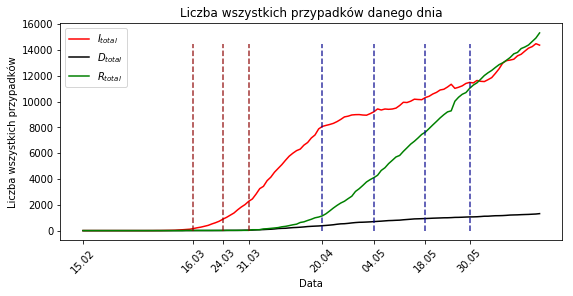

In [84]:
plt.figure(figsize=(9,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r', label=r'$I_{total}$')
plt.plot(Dtotal, 'k', label=r'$D_{total}$')
plt.plot(Rtotal, 'g', label=r'$R_{total}$')

mx = np.ceil(np.max(Itotal))
plt.plot([r0,r0],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([r1,r1],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([r2,r2],[0,mx], '--', c='darkred', alpha=0.8)
plt.plot([f0,f0],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f1,f1],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f2,f2],[0,mx], '--', c='darkblue', alpha=0.8)
plt.plot([f3,f3],[0,mx], '--', c='darkblue', alpha=0.8)

my_xticks = ['15.02','16.03','24.03','31.03','20.04','04.05','18.05','30.05']
x = [0,r0,r1,r2,f0,f1,f2,f3]
plt.xticks(x, my_xticks, rotation=45)

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/poland_total.png', bbox_inches='tight')

## Poland
### 1st period 

R2 : 0.8478941657459403
MSE : 10.634563905113831
chi: 27.093377223567852 v: 27 1.0034584156876982
pval: 0.45876546122549783
Param : [0.01957554 0.25311105]
Std Err param : [0.0194541  0.03608641]
dI1 :  30.166915256897422 +- 43.53668086102919


/home/marek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


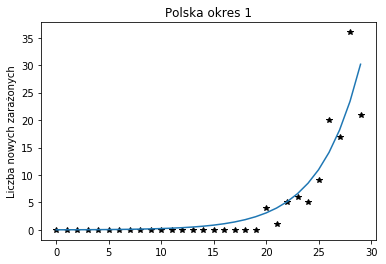

In [85]:
y = Idaily[:r0]
x = np.arange(0,r0)

p0=[1, 4000, 3000]
pe, param_cov_e = curve_fit(my_exp, x, y) 
pg, param_cov_g = curve_fit(my_gauss, x, y, p0=p0)
ps0=[0.15,45,500]
ps, param_cov_g = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(x,y,'k*')
plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_sigmoid(x,ps))
#plt.plot(x,my_gauss(x,pg))

chi, pval = chisquare(y, my_exp(x,pe), len(pe))
R2 = r2_score(y, my_exp(x,pe))
MSE = mse(y, my_exp(x,pe))
print('R2 :', R2)
print('MSE :', MSE)
dof = len(x)-len(pe)-1
print('chi:', chi, 'v:', dof, chi/dof)
print('pval:',pval)

plt.title('Polska okres 1')
plt.ylabel('Liczba nowych zarażonych')
plt.savefig('images/poland_1.png', bbox_inches='tight')
dI1=int(my_exp(x[-1],pe))

def exp_error(x, pe, dpe):
    a, b = pe
    da, db = dpe
    err = np.sqrt( (np.exp(b*x)*da)**2 + (a*np.exp(b*x)*x*db)**2)
    return err

param_error = np.sqrt(np.diag(param_cov_e))
print('Param :', pe)
print('Std Err param :', param_error)
xx = x[-1]
print('dI1 : ',my_exp(xx,pe),'+-',exp_error(xx, pe, param_error))
eI1 = exp_error(xx, pe, param_error)

### 2st period 

R2 : 0.9575701401483238
chi: 83.9644837981535 v: 35
pval: 6.642678872743638e-06
38
param : [0.22779842 0.17054823]
Std Err param : [0.08109864 0.01026968]
dI2 :  125 +- 65.26173521121345
param : [0.22779842 0.17054823]
Std Err param : [0.08109864 0.01026968]
dI1 :  32.02780505071541 +- 14.865891484072096


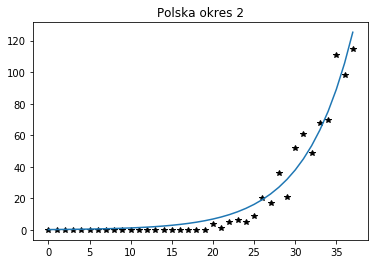

In [87]:
y = Idaily[r0:r1]
x = np.arange(0,r1-r0)
y1 = Idaily[0:r1]
x1 = np.arange(0,r1)

#p0 = [1, 4000, 3000]
pe, param_cov_e = curve_fit(my_exp, x, y) 
pe1, param_cov_e1 = curve_fit(my_exp, x1, y1) 
#pg, param_cov_g = curve_fit(my_gauss, x, y, p0=p0)

plt.plot(x1,y1,'k*')
plt.plot(x1,my_exp(x1,pe1))
#plt.plot(x+r0,my_exp(x,pe))

chi, pval = chisquare(y1, my_exp(x1,pe1), len(pe1))
R2 = r2_score(y1, my_exp(x1,pe1))
print('R2 :', R2)
print('chi:', chi, 'v:', len(x1)-len(pe1)-1)
print('pval:',pval)

plt.title('Polska okres 2')
plt.ylabel('')
plt.savefig('images/poland_2.png', bbox_inches='tight')
dI2=int(my_exp(x1[-1],pe1))

param_error1 = np.sqrt(np.diag(param_cov_e1))
print('param :', pe1)
print('Std Err param :', param_error1)
print('dI2 : ',dI2,'+-',exp_error(x1[-1], pe1, param_error1))
eI2 = exp_error(x1[-1], pe1, param_error1)

param_error1 = np.sqrt(np.diag(param_cov_e1))
print('param :', pe1)
print('Std Err param :', param_error1)
print('dI1 : ',my_exp(x1[29],pe1),'+-',exp_error(x1[29], pe1, param_error1))
dI1=int(my_exp(x1[29],pe1))
eI1 = exp_error(x1[29], pe1, param_error1)

### 3rd period 

R2 : 0.9751346478791352
chi: 68.447307173041 v: 41
pval: 0.0045665450400928604
param : [2.39523262e-01 3.75434953e+01 2.69676708e+02]
Std Err param : [ 0.02559527  0.98641337 25.49313444]
dI3 :  222 +- 21.016713938037807


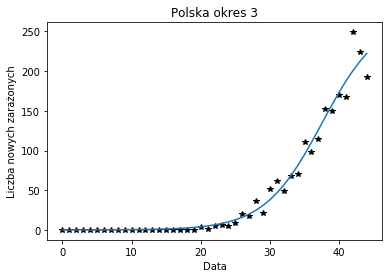

In [35]:
y = Idaily[0:r2]
x = np.arange(0,r2)

ps0=[0.15,45,500]
pg0=[500, 2000, 300]
pe, param_cov_e = curve_fit(my_exp, x, y) 
#pg, param_cov_g = curve_fit(my_gauss, x, y, p0=pg0, maxfev=2000)
ps, param_cov_s = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_gauss(x,pg))
plt.plot(x,my_sigmoid(x,ps))

chi, pval = chisquare(y, my_sigmoid(x,ps), len(ps))
R2 = r2_score(y, my_sigmoid(x,ps))
print('R2 :', R2)
print('chi:', chi, 'v:', len(x)-len(ps)-1)
print('pval:',pval)

plt.title('Polska okres 3')
plt.xlabel('Data')
plt.ylabel('Liczba nowych zarażonych')
plt.savefig('images/poland_3.png', bbox_inches='tight')
dI3=int(my_sigmoid(x[-1],ps))

def sig_error(x, pe, dpe):
    a, b, c = pe
    da, db, dc = dpe
    ps1 = ps
    ps1[2] = 1
    err = np.sqrt((my_sigmoid(x,ps)*my_sigmoid(x,ps1)*np.exp(-a*(x-b))*(b-x)*da)**2+
                  (my_sigmoid(x,ps)*my_sigmoid(x,ps1)*np.exp(-a*(x-b))*a*db)**2+
                  (my_sigmoid(x,ps1)*dc)**2 )
    return err

param_error = np.sqrt(np.diag(param_cov_s))
print('param :', ps)
print('Std Err param :', param_error)
print('dI3 : ',dI3,'+-',sig_error(x[-1], ps, param_error))
eI3 = sig_error(x[-1], ps, param_error)

### 4th period 

R2 : 0.9247608464359028


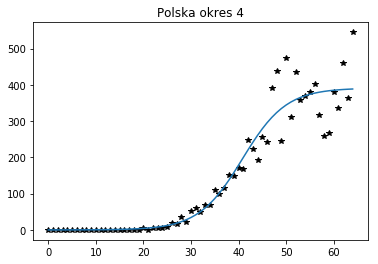

param : [2.17082686e-01 4.08036446e+01 3.91029864e+02]
Std Err param : [ 0.02559527  0.98641337 25.49313444]
dI4 :  64 +- 25.328429825409767


In [36]:
y = Idaily[0:f0]
x = np.arange(0,f0)

ps0=[0.15,45,500]
pg0=[500, 2000, 300]
pe, param_cov_e = curve_fit(my_exp, x, y) 
#pg, param_cov_g = curve_fit(my_gauss, x, y, p0=pg0, maxfev=2000)
ps, param_cov_g = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_gauss(x,pg))
plt.plot(x,my_sigmoid(x,ps))

chi, pval = chisquare(y, my_sigmoid(x,ps),len(ps))
R2 = r2_score(y, my_sigmoid(x,ps))
print('R2 :', R2)

plt.title('Polska okres 4')
plt.show()

param_error = np.sqrt(np.diag(param_cov_s))
print('param :', ps)
print('Std Err param :', param_error)
print('dI4 : ',x[-1], '+-',sig_error(x[-1], ps, param_error))

R2 : 0.8789027715105414
chi: 1130.5239899866883 v: 101 pval: 0.0
pval: 1.4236886742361208e-173
param : [2.55050671e-01 3.97146602e+01 3.56138294e+02]
Std Err param : [0.04839111 0.85521995 8.36830255]
dI4 :  356 +- 8.368301912879653


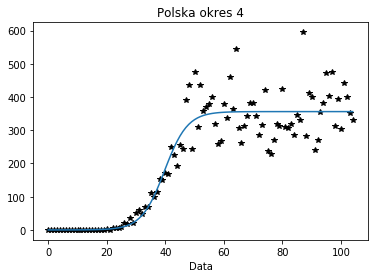

In [37]:
y = Idaily[0:f3]
x = np.arange(0,f3)

ps0=[0.15,45,500]
pg0=[500, 2000, 300]
pe, param_cov_e = curve_fit(my_exp, x, y) 
#pg, param_cov_g = curve_fit(my_gauss, x, y, p0=pg0, maxfev=2000)
ps, param_cov_s = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_gauss(x,pg))
plt.plot(x,my_sigmoid(x,ps))

chi, pval = chisquare(y, my_sigmoid(x,ps),len(ps))
R2 = r2_score(y, my_sigmoid(x,ps))
#chi = np.sum((y - my_sigmoid(x,ps))**2)
print('R2 :', R2)
print('chi:', chi, 'v:', len(x)-len(ps)-1, 'pval:', 1 - chi2.cdf(chi,len(x)-len(ps)-1))
print('pval:',pval)


plt.title('Polska okres 4')
plt.xlabel('Data')
plt.ylabel('')
plt.savefig('images/poland_4.png', bbox_inches='tight')
dI4=int(my_sigmoid(x[-1],ps))

param_error = np.sqrt(np.diag(param_cov_s))
print('param :', ps)
print('Std Err param :', param_error)
print('dI4 : ',dI4, '+-',sig_error(x[-1], ps, param_error))
eI4 = sig_error(x[-1], ps, param_error)

R2 : 0.7542136926793531
param : [ 0.16817737 64.46759885  1.        ]
Std Err param : [ 0.04115165  1.72345526 14.72553093]
dR1 :  0 +- 0.044809294472366146
dR2 :  3 +- 0.17026301722441953
dR3 :  9 +- 0.5379278487215324
dR4 :  266 +- 14.706471164975866


/home/marek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


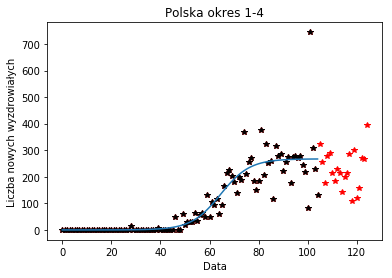

In [38]:
y = Rdaily[:f3]
x = np.arange(0,f3)

pe, param_cov_e = curve_fit(my_exp, x, y) 
pg, param_cov_g = curve_fit(my_gauss, x, y, p0=p0)
ps, param_cov_s = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(Rdaily,'r*')
plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
#plt.plot(x,my_gauss(x,pg))
plt.plot(x,my_sigmoid(x,ps))
dR1=int(my_sigmoid(x[r0],ps))
dR2=int(my_sigmoid(x[r1],ps))
dR3=int(my_sigmoid(x[r2],ps))
dR4=int(my_sigmoid(x[-1],ps))

chi, pval = chisquare(y, my_gauss(x,pg), len(pg))
R2 = r2_score(y, my_gauss(x,pg))
chi = np.sum((y - my_gauss(x,pg))**2 / sig_error(x, ps, param_error))
print('R2 :', R2)
#print('chi:', chi, 'v:', len(x)-len(pe)-1, 'pval:', 1 - chi2.cdf(chi,len(x)-len(pe)-1))

def gauss_error(x, pe, dpe):
    a, m, s = pe
    da, dm, ds = dpe
    err = np.sqrt((my_gauss(x,pe)*da)**2+
                 (my_gauss(x,pe)*(x-m)/s/s*dm)**2+
                 (my_gauss(x,pe)*(x-m)**2/s/s/s*ds)**2)
    return err

plt.title('Polska okres 1-4')
plt.xlabel('Data')
plt.ylabel('Liczba nowych wyzdrowiałych')
plt.savefig('images/poland_R.png', bbox_inches='tight')


param_error = np.sqrt(np.diag(param_cov_s))
print('param :', ps)
print('Std Err param :', param_error)
print('dR1 : ',dR1, '+-',sig_error(x[r0], ps, param_error))
print('dR2 : ',dR2, '+-',sig_error(x[r1], ps, param_error))
print('dR3 : ',dR3, '+-',sig_error(x[r2], ps, param_error))
print('dR4 : ',dR4, '+-',sig_error(x[-1], ps, param_error))
eR1 = sig_error(x[r0], ps, param_error)
eR2 = sig_error(x[r1], ps, param_error)
eR3 = sig_error(x[r2], ps, param_error)
eR4 = sig_error(x[-1], ps, param_error)

R2 : 0.7346324302818457
chi: 317816.8298987295 v: 101 pval: 0.0
pval: 5.745722288352747e-10
param : [289.38053942  71.74903847  19.06226912]
Std Err param : [11.30232148  1.0873412   1.16766287]
dD1 :  2 +- 24.076028129559738
dD2 :  4 +- 55.2622140010365
dD3 :  8 +- 98.9592233398056
dD4 :  5 +- 63.31435388094213


/home/marek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


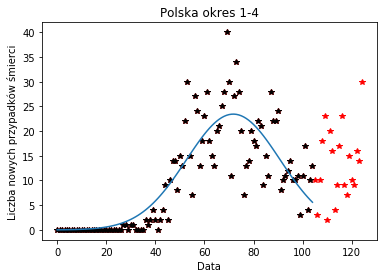

In [39]:
y = Ddaily[:f3]
x = np.arange(0,f3)

pe, param_cov_e = curve_fit(my_exp, x, y) 
pg, param_cov_g = curve_fit(my_gauss, x, y, p0=p0)
ps, param_cov_s = curve_fit(my_sigmoid, x, y, p0=ps0)

plt.plot(Ddaily,'r*')
plt.plot(x,y,'k*')
#plt.plot(x,my_exp(x,pe))
plt.plot(x,my_gauss(x,pg))
#plt.plot(x,my_sigmoid(x,ps))

chi, pval = chisquare(y, my_gauss(x,pg), len(pg))
R2 = r2_score(y, my_gauss(x,pg))
chi = np.sum((y - my_gauss(x,pg))**2 / sig_error(x, ps, param_error))
print('R2 :', R2)
print('chi:', chi, 'v:', len(x)-len(pg)-1, 'pval:', 1 - chi2.cdf(chi,len(x)-len(pg)-1))
print('pval:',pval)

plt.title('Polska okres 1-4')
plt.xlabel('Data')
plt.ylabel('Liczba nowych przypadków śmierci')
plt.savefig('images/poland_D.png', bbox_inches='tight')
dD1=int(my_gauss(x[r0],pg))
dD2=int(my_gauss(x[r1],pg))
dD3=int(my_gauss(x[r2],pg))
dD4=int(my_gauss(x[-1],pg))

param_error = np.sqrt(np.diag(param_cov_g))
print('param :', pg)
print('Std Err param :', param_error)
print('dD1 : ',dD1, '+-',gauss_error(x[r0], pg, param_error))
print('dD2 : ',dD2, '+-',gauss_error(x[r1], pg, param_error))
print('dD3 : ',dD3, '+-',gauss_error(x[r2], pg, param_error))
print('dD4 : ',dD4, '+-',gauss_error(x[-1], pg, param_error))
eD1 = gauss_error(x[r0], pg, param_error)
eD2 = gauss_error(x[r1], pg, param_error)
eD3 = gauss_error(x[r2], pg, param_error)
eD4 = gauss_error(x[-1], pg, param_error)

### Computed Values

In [40]:
print(dI1,dI2,dI3,dI4)
print(dR1,dR2,dR3,dR4)
print(dD1,dD2,dD3,dD4)

32 125 222 356
0 3 9 266
2 4 8 5


In [41]:
print(eI1,eI2,eI3,eI4)
print(eR1,eR2,eR3,eR4)
print(eD1,eD2,eD3,eD4)

14.865891484072096 65.26173521121345 21.016713938037807 8.368301912879653
0.044809294472366146 0.17026301722441953 0.5379278487215324 14.706471164975866
24.076028129559738 55.2622140010365 98.9592233398056 63.31435388094213


In [42]:
print(Itotal[[r0-5,r1-5,r2-5,f3-5]])
print(Rtotal[[r0-15,r1-15,r2-15,f3-15]])
print(Dtotal[[r0-15,r1-15,r2-15,f3-15]])

[   31.   337.  1198. 11348.]
[   0.    0.   13. 6930.]
[  0.   0.   4. 907.]


In [46]:
I_15 = Itotal[[r0-15,r1-15,r2-15,f3-15]]
I_15[I_15==0]=1
print(np.array([eR1,eR2,eR3,eR4])/I_15)
print(np.array([eD1,eD2,eD3,eD4])/I_15)
gm = np.array([eR1,eR2,eR3,eR4])/I_15
bt = np.array([eD1,eD2,eD3,eD4])/I_15

[0.04480929 0.01001547 0.00336205 0.00144308]
[2.40760281e+01 3.25071847e+00 6.18495146e-01 6.21277145e-03]


In [47]:
print(np.sqrt((np.array([eI1,eI2,eI3,eI4])/I_15)**2+
             (gm)**2+(bt)**2))

[2.82957924e+01 5.03036983e+00 6.32298619e-01 6.43080885e-03]


### Calculation od model

Iitialize parameters

In [48]:
# Total population, N.
N = 37 * 10**6

Function to count derivatives <br>
credit: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

In [49]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma, delta):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I - delta * I
    dRdt = gamma * I
    dDdt = delta * I
    return dSdt, dIdt, dRdt, dDdt

parameter estimation: https://www.hindawi.com/journals/ddns/2018/3187807/ <br>
https://www.statsandr.com/blog/covid-19-in-belgium/

In [88]:
def plot_SIR(I0,R0,D0, dI,dR,dD, tit,t_max=200):
    # Initial number of infected and recovered individuals, I0, R0, D0.
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0 - D0
    # parameters
    gamma = dR/I0
    delta = dD/I0
    beta = (dI + (gamma-delta)*I0)*N/(S0*I0)
    print('beta =',beta,'beta_2 =',dI/S0/I0)
    print('gamma =',gamma)
    print('delta =',delta)
    
    # A grid of time points (in days)
    t = np.linspace(0, t_max, t_max)
    
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
    S, I, R, D = ret.T
    
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure()
    plt.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='S')
    plt.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='I')
    plt.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='R')
    plt.plot(t, D/1000, 'k', alpha=0.5, lw=2, label='D')
    
    plt.xlabel('Dzień')
    plt.ylabel('Liczba przypadków (tysiące)')
    legend = plt.legend()
    legend.get_frame().set_alpha(0.5)
    plt.title(tit)    
    return S, I, R, D

def compute_SIRD(I0,R0,D0, Itrue, beta, gamma, delta, t_max=200):
    # Initial number of infected and recovered individuals, I0, R0, D0.
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0 - D0
    # parameters
    #print('beta =',beta)
    #print('gamma =',gamma)
    #print('delta =',delta)
    
    # A grid of time points (in days)
    t = np.linspace(0, t_max, t_max)
    
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
    S, I, R, D = ret.T
    
    rate = np.sum((I[:Itrue.shape[0]]-Itrue)**2)
    
    return S, I, R, D, rate

Plotting results

beta = 0.9677427462953611 beta_2 = 2.789888998328969e-08
gamma = 0.0
delta = 0.06451612903225806
beta = 0.367955873637069 beta_2 = 1.0024952965264521e-08
gamma = 0.008902077151335312
delta = 0.011869436201780416
beta = 0.18614968537421694 beta_2 = 5.008511714104492e-09
gamma = 0.007512520868113523
delta = 0.00667779632721202
beta = 0.05439902086783666 beta_2 = 8.483092307569254e-10
gamma = 0.02344025378921396
delta = 0.0004406062742333451
[0.04480929 0.01001547 0.00336205 0.00144308]
[2.40760281e+01 3.25071847e+00 6.18495146e-01 6.21277145e-03]


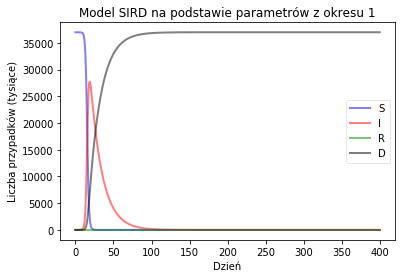

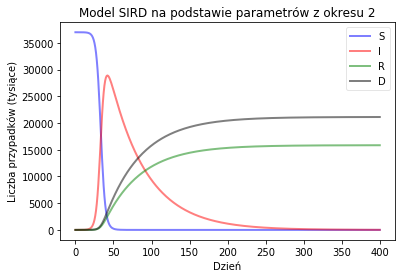

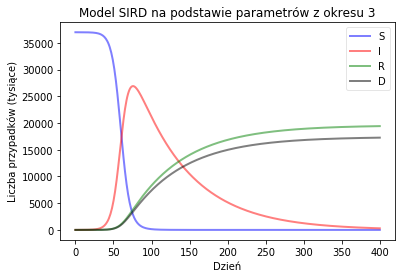

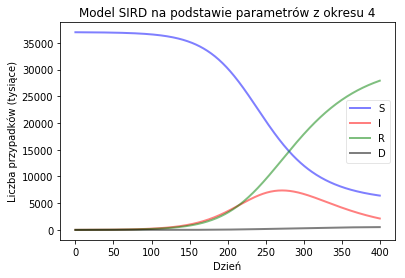

In [89]:
Itab = []
for i, nt in enumerate([r0,r1,r2,f3]):
    dValuse = [[dI1,dR1,dD1],
              [dI2,dR2,dD2],
              [dI3,dR3,dD3],
              [dI4,dR4,dD4]]
    S, I, R, D  = plot_SIR(Itotal[nt-5],Rtotal[nt-15],Dtotal[nt-15], 
                           dValuse[i][0],dValuse[i][1],dValuse[i][2],
                           tit='Model SIRD na podstawie parametrów z okresu '+str(i+1),
                           t_max=400)
    Itab.append(I)
    
    plt.savefig('images/poland_SIRD'+str(i+1)+'.png', bbox_inches='tight')

print(np.array([eR1,eR2,eR3,eR4])/I_15)
print(np.array([eD1,eD2,eD3,eD4])/I_15)

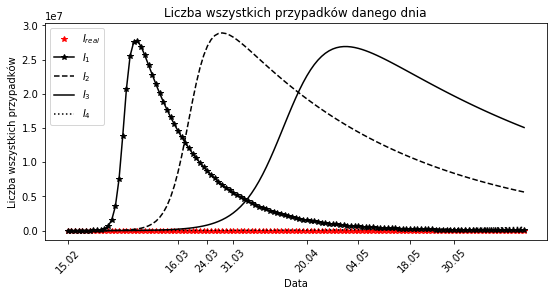

In [53]:
plt.figure(figsize=(9,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(Itab[0][:len(Itotal)],'k-*', label=r'$I_{1}$')
plt.plot(Itab[1][:len(Itotal)],'k--', label=r'$I_{2}$')
plt.plot(Itab[2][:len(Itotal)],'k-', label=r'$I_{3}$')
plt.plot(Itab[3][:len(Itotal)],'k:', label=r'$I_{4}$')

my_xticks = ['15.02','16.03','24.03','31.03','20.04','04.05','18.05','30.05']
x = [0,r0,r1,r2,f0,f1,f2,f3]
plt.xticks(x, my_xticks, rotation=45)

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/poland_compare.png', bbox_inches='tight')

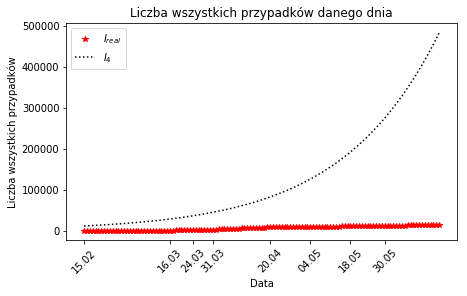

In [54]:
plt.figure(figsize=(7,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r*', label=r'$I_{real}$')
plt.plot(Itab[3][:len(Itotal)],'k:', label=r'$I_{4}$')

my_xticks = ['15.02','16.03','24.03','31.03','20.04','04.05','18.05','30.05']
x = [0,r0,r1,r2,f0,f1,f2,f3]
plt.xticks(x, my_xticks, rotation=45)

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Data')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/poland_compare_best.png', bbox_inches='tight')

# SIR model

In [70]:
# The SIR model differential equations.
def deriv2(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [71]:
def SIR(I0,R0,N, dI,dR, tit,t_max=200, dt=50):
    # Initial number of infected and recovered individuals, I0, R0, D0.
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0 
    # parameters
    gamma = dR/I0
    beta = (dI + gamma*I0)*N/(S0*I0)
    print('beta =',beta)
    print('gamma =',gamma)
    
    # A grid of time points (in days)
    t = np.linspace(0, t_max, t_max)
    
    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv2, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    
    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure()
    plt.plot(t+dt, S/1000, 'b', alpha=0.5, lw=2, label='S')
    plt.plot(t+dt, I/1000, 'r', alpha=0.5, lw=2, label='I')
    plt.plot(t+dt, R/1000, 'g', alpha=0.5, lw=2, label='R')
    
    plt.xlabel('Dzień')
    plt.ylabel('Liczba przypadków (tysiące)')
    legend = plt.legend()
    legend.get_frame().set_alpha(0.5)
    plt.title(tit)    

## Malaysia

In [72]:
names, datas, dates = get_data(mal)

datas shape: (7, 125)
0 Cases
1 Cases
2 Daily Cases
3 Currently Infected
4 Deaths
5 Deaths
6 Daily Deaths


In [73]:
Itotal = datas[3]
Rtotal = np.cumsum(datas[2]) - datas[3]

Idaily = datas[2]
Rdaily = np.diff(Rtotal)
Rdaily[Rdaily<0] = 0

In [74]:
x = np.arange(0,Idaily.shape[0])

pg, param_cov_g = curve_fit(my_gauss, x, Idaily,p0=[100,60,40])
pg1, param_cov_g1 = curve_fit(my_gauss, x[:-1], Rdaily, p0=[100,60,40])

/home/marek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


R2_R : 0.28776793587752214
R2_I : 0.4171428283390429
param : [ 0.4561948 45.8282236  1.       ]
Std Err param : [105.51526243   1.32579371   1.32770032]
dR :  80.26912193504913 +- 9278.327326170398
dI :  162.38674040781214 +- 17134.279579377537


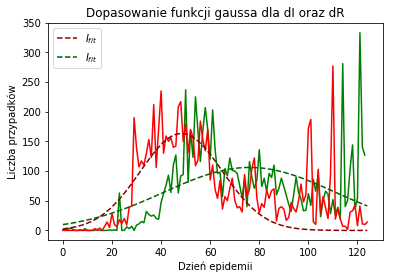

In [75]:
plt.plot(Rdaily,'g')
plt.plot(Idaily,'r')

plt.plot(x,my_gauss(x,pg),'--',c='darkred', label=r'$I_{fit}$')
plt.plot(x,my_gauss(x,pg1),'--',c='darkgreen', label=r'$I_{fit}$')

plt.legend()
plt.title('Dopasowanie funkcji gaussa dla dI oraz dR')
plt.xlabel('Dzień epidemii')
plt.ylabel('Liczba przypadków')

plt.savefig('images/malysian_fit.png', bbox_inches='tight')
day = 50
dR = my_gauss(x,pg1)[day]
dI = my_gauss(x,pg)[day]

R2 = r2_score(Rdaily, my_gauss(x,pg1)[:-1])
print('R2_R :', R2)

R2 = r2_score(Idaily, my_gauss(x,pg))
print('R2_I :', R2)

param_error1 = np.sqrt(np.diag(param_cov_g1))
param_error = np.sqrt(np.diag(param_cov_g))
print('param :', ps)
print('Std Err param :', param_error)
print('dR : ',dR, '+-',gauss_error(x[day], pg1, param_error1))
print('dI : ',dI, '+-',gauss_error(x[day], pg, param_error))

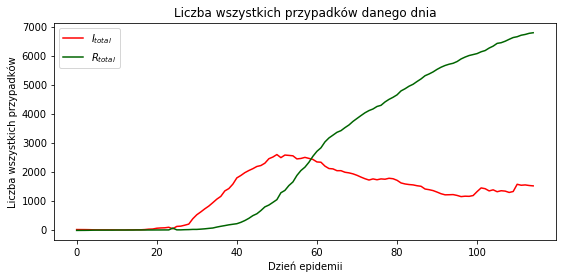

In [741]:
plt.figure(figsize=(9,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r', label=r'$I_{total}$')
plt.plot(Rtotal, 'darkgreen', label=r'$R_{total}$')

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Dzień epidemii')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/malysia_total.png', bbox_inches='tight')

In [742]:
N = 31*10**6

beta = 0.10103267859435697
gamma = 0.03845321590523187


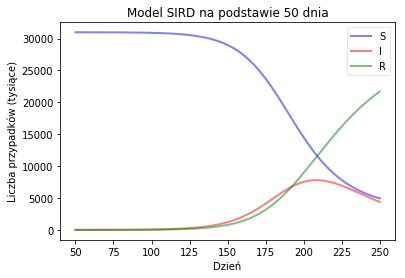

In [743]:
SIR(Itotal[day],Rtotal[day],N, dI,dR,'Model SIRD na podstawie '+str(day)+' dnia', t_max=200, dt=day)
plt.savefig('images/malysia_SIR_'+str(day)+'.png', bbox_inches='tight')

## Belgium

In [122]:
names, datas, dates = get_data(bg)

datas shape: (11, 124)
0 Currently Infected
1 Death Rate
2 Cases
3 Cases
4 Daily Cases
5 Currently Infected
6 Deaths
7 Deaths
8 Daily Deaths
9 New Recoveries
10 Death Rate


In [123]:
Itotal = datas[0]
Rtotal = np.cumsum(datas[9]) + np.cumsum(datas[8])

Idaily = datas[4]
Rdaily = datas[-3] + datas[-2]

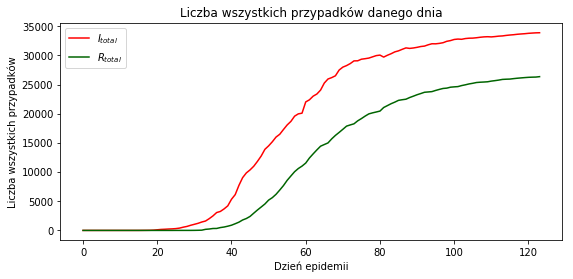

In [124]:
plt.figure(figsize=(9,4))
#np.cumsum(Idaily)-Dtotal-Rtotal
plt.plot(Itotal,'r', label=r'$I_{total}$')
plt.plot(Rtotal, 'darkgreen', label=r'$R_{total}$')

#plt.plot(np.cumsum(datas[9]), 'g', label=r'$R$')
#plt.plot(np.cumsum(datas[8]), 'k', label=r'$D$')

plt.title('Liczba wszystkich przypadków danego dnia')
plt.xlabel('Dzień epidemii')
plt.ylabel('Liczba wszystkich przypadków')
plt.legend()
plt.savefig('images/belgium_total.png', bbox_inches='tight')

In [125]:
def my_gauss2(x, a, mu=0, sigma=0, b=1):
    if type(a) is np.ndarray:
        a, mu, sigma,b = a
    return a*np.exp(-(x-mu)**2/(2*sigma**2)) + b

R2_R : 0.8002707371341786
R2_I : 0.8232087464099067


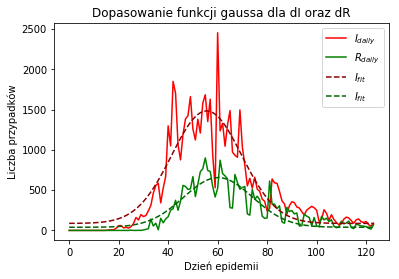

In [128]:
y = Idaily
x = np.arange(0,Rdaily.shape[0])

p0 = [300,100,150,1]
p01 = [100,50,150,1]

pg, param_cov_g = curve_fit(my_gauss2, x, Idaily, p0=p0)
pg1, param_cov_g = curve_fit(my_gauss2, x, Rdaily, p0=p01)


plt.plot(Idaily,'r', label=r'$I_{daily}$')
plt.plot(Rdaily, 'g', label=r'$R_{daily}$')

plt.plot(my_gauss2(x,pg),'--',c='darkred', label=r'$I_{fit}$')
plt.plot(my_gauss2(x,pg1),'--',c='darkgreen', label=r'$I_{fit}$')

plt.legend()
plt.title('Dopasowanie funkcji gaussa dla dI oraz dR')
plt.xlabel('Dzień epidemii')
plt.ylabel('Liczba przypadków')

plt.savefig('images/belgium_fit.png', bbox_inches='tight')
day = 40
dR = my_gauss2(x,pg1)[day]
dI = my_gauss2(x,pg)[day]


R2 = r2_score(Rdaily, my_gauss2(x,pg1))
print('R2_R :', R2)

R2 = r2_score(Idaily, my_gauss2(x,pg))
print('R2_I :', R2)

In [ ]:
N = 11*10**6

beta = 0.20652671591248492
gamma = 0.04752168275722096


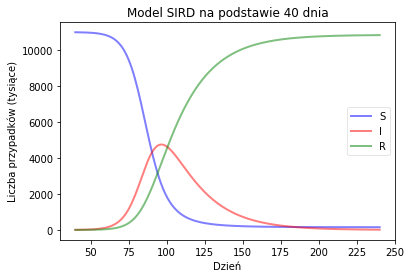

In [756]:
SIR(Itotal[day],Rtotal[day],N, dI,dR,'Model SIRD na podstawie '+str(day)+' dnia', t_max=200, dt=day)
plt.savefig('images/belgium_SIR_'+str(day)+'.png', bbox_inches='tight')

# Fit differentail equation to data
http://adventuresinpython.blogspot.com/2012/08/fitting-differential-equation-system-to.html